In [1]:
from keras.layers import Input, Conv2D, Lambda, subtract, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy as np
import numpy.random as rng
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

In [0]:
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))
#encode each of the two inputs into a vector with the convnet

In [0]:
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

In [5]:
!git clone https://github.com/brendenlake/omniglot.git
!unzip -q omniglot/python/images_background.zip 

Cloning into 'omniglot'...
remote: Enumerating objects: 67, done.
remote: Total 67 (delta 0), reused 0 (delta 0), pack-reused 67
Unpacking objects: 100% (67/67), done.


In [6]:
from PIL import Image

train_x = np.zeros((19280,105,105))
print(train_x.shape)
train_y = np.zeros((19280))

print(train_x.shape)

i=0
arc = os.path.join("images_background")
for alphabet in os.listdir(arc):
    for characters in os.listdir(os.path.join(arc,alphabet)):
        for sub in os.listdir(os.path.join(arc,alphabet,characters)):
            path = os.path.join(arc,alphabet,characters,sub)
            img = Image.open(path)
            train_x[i,:,:] = np.asarray(img.getdata()).reshape(img.size)
            train_y[i] = int(path[path.find('.png')-7:path.find('.png')-3])
            #print(train_y[i])
            i += 1  

(19280, 105, 105)
(19280, 105, 105)


In [7]:
both = subtract([encoded_l,encoded_r])
pred = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)

Siamese = Model(input=[left_input,right_input],output=pred)
Siamese.compile(loss='binary_crossentropy',optimizer=Adam(0.006))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [8]:
left, right = 4,500
out1 =Siamese.predict([train_x[left,:,:].reshape((1,105,105,1)),train_x[right,:,:].reshape((1,105,105,1))])
print(type(out1))
print(np.sum(out1))
print(train_y[left],train_y[right])

<class 'numpy.ndarray'>
0.6065808
125.0 573.0


In [0]:
 def generate_trainset(train_x,train_y, size):
  
  pairs = [np.zeros((size,105,105)) for i in range(2)]
  targets = np.zeros((size))
  
  print("pairs",np.asarray(pairs).shape,"targets",np.asarray(targets).shape)
  train_y_structured = train_y.reshape(-1,20)
  train_x_structured = train_x.reshape(-1,20,105,105)
  #print("structured x,",train_x_structured.shape)
  #print("structured y,",train_y_structured.shape)
  randed = rng.choice(train_y_structured.shape[0],size,replace=False)
  #print("trainx",train_x_structured[randed].shape,train_x_structured.shape)
  
  left = train_x_structured[0,0,:,:]
  right= train_x_structured[0,0,:,:]
  for i in range(0,size):
    if i < size//2:
      class_of_char = rng.randint(963)
      print("class same:",class_of_char)
      left =train_x_structured[class_of_char,rng.randint(19),:,:]
      right =train_x_structured[class_of_char,rng.randint(19),:,:]
      pairs[0][i,:,:] = left.reshape(105,105)
      pairs[1][i,:,:] = right.reshape(105,105)
      targets[i] = 1
      
    else:
      indexes = rng.choice(963,size=2,replace=False)
      print("two of em",indexes.shape,indexes)
      left = train_x_structured[indexes[0],rng.randint(19),:,:]
      right= train_x_structured[indexes[1],rng.randint(19),:,:]
      pairs[0][i,:,:] = left.reshape(105,105)
      pairs[1][i,:,:] = right.reshape(105,105)
      targets[i] = 0
      
  '''both = np.zeros([2,105,105])
  both[0,:,:] = left.reshape(105,105)
  both[1,:,:] = right.reshape(105,105)
  
  plt.imshow(both.reshape(2*105,105))
  print(train_y.shape,randed)'''

  return [np.asarray(pairs),targets]

(19280, 105, 105) (19280,)
pairs (2, 4, 105, 105) targets (4,)
class same: 376
class same: 276
two of em (2,) [744 773]
two of em (2,) [130 324]
(2, 4, 105, 105)


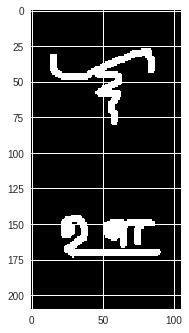

In [101]:
size = 200
train_x_generated = np.zeros((size,105,105))
train_y_generated = np.zeros((size))

'''print(train_x.shape)
np.random.choice(train_y[0:200],100,replace=False)


print("structed",train_y_structured.shape)
print("train_y",train_y.shape)
print(train_y[0:20])
print(train_y_structured[0,:])'''
print(train_x.shape,train_y.shape)
[mypairs,mytargets] = generate_trainset(train_x,train_y,4)
print(mypairs.shape)
plt.imshow(mypairs[:,3,:,:].reshape(2*105,105))